In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns



The 3 images shown - are their resulting activations?


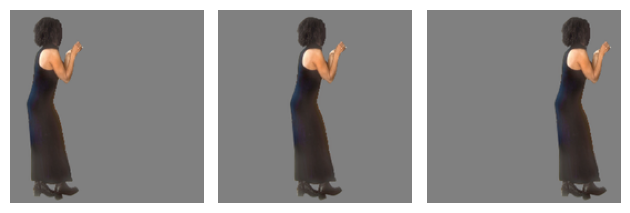

['stimulus7_left.tif', 'stimulus7.tif', 'stimulus7_right.tif']

In [2]:
# First do some analysis on the translation test - see if my understanding of representations are right

path2activations = '/data/alban/activations/saycam_hmIT_Translationtest'
#path2dataset = 'testsets/hmIT_Translationtest'
path2dataset = 'testsets/hmIT_Translationtest'

listimages = os.listdir(path2dataset)
fig, subs = plt.subplots(1,3)
for i, img in enumerate(listimages):
    img = cv2.imread(join(path2dataset, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    subs[i].imshow(img)
    subs[i].axis('off')
print('The 3 images shown - are their resulting activations?')
fig.tight_layout()
plt.show()

listimages

In [3]:
cls_token = list()
patch_token = list()
for i, im in enumerate(listimages):
    cls_token.append(np.load(join(path2activations, f'cls_token_{im[:-4]}.npy')))
    patch_token.append(np.load(join(path2activations, f'patch_token_{im[:-4]}.npy')))
cls_token = np.array(cls_token)
patch_token = np.array(patch_token).reshape(3,-1)
patch_token.shape

(3, 7680000)

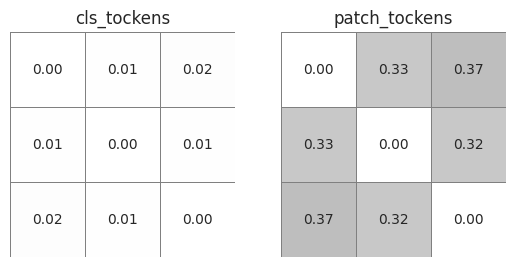

In [4]:
### Correlations
corr_cls = np.corrcoef(cls_token)
corr_patch = np.corrcoef(patch_token)

fig, subs = plt.subplots(1,2)
# Using a different colormap that goes from blue (similar) to red (dissimilar)
sns.heatmap(1- corr_cls,
            annot=True,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            linecolor='grey',
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(1- corr_patch,
            annot=True,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            linecolor='grey',
            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

subs[0].set_title('cls_tockens')
subs[1].set_title('patch_tockens')

subs[0].axis('off')
subs[1].axis('off')

plt.show()



In [5]:
## Dot product

def similarity_dotproduct(vectors):
    vectors_normalized = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    # Compute similarity matrix (cosine similarity)
    similarity_matrix = np.dot(vectors_normalized, vectors_normalized.T)
    # Convert to dissimilarity: 1 - similarity
    return 1 - similarity_matrix

dot_cls = similarity_dotproduct(cls_token)
dot_patch = similarity_dotproduct(patch_token)



Let's try with L2 norm as a metric of similarity (after normalization). nt

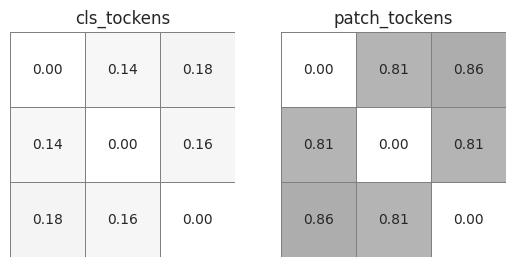

In [6]:
## L2 norm

from scipy.spatial.distance import pdist, squareform

def similarity_L2norm(vectors):
    vectors_normalized = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    # Compute similarity matrix (l2 norm similarity)
    distances = pdist(vectors_normalized, 'euclidean')
    # Convert to dissimilarity: 1 - similarity
    return squareform(distances)

l2_cls = similarity_L2norm(cls_token)
l2_patch = similarity_L2norm(patch_token)

fig, subs = plt.subplots(1,2)
# Using a different colormap that goes from blue (similar) to red (dissimilar)
sns.heatmap(l2_cls,
            annot=True,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            linecolor='grey',
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=2)               # Set maximum value for color scale

sns.heatmap(l2_patch,
            annot=True,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            fmt='.2f',
            linewidths=0.5,
            linecolor='grey',
            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=2)               # Set maximum value for color scale

subs[0].set_title('cls_tockens')
subs[1].set_title('patch_tockens')

subs[0].axis('off')
subs[1].axis('off')

plt.show()


As we did expect, we have low dissimilarity scores when using the cls_tokens as representations, and mid when suing the patch tokens. This suggests that the cls tokens are largely agnostic of spatial properties, and thus more appropriate to compare how semantic information is being represented.

Let's do the same with the actual 92 images.

In [7]:
# Get image paths and the dataset's metadata
from natsort import natsorted
import pandas as pd

df = pd.read_excel('testsets/metadata_hmIT/mapping.xlsx')
print(df)


       class1      class2  class3     image  informed_exclude
0     animate       human    body  0001.jpg                 0
1     animate       human    body  0002.jpg                 0
2     animate       human    body  0003.jpg                 0
3     animate       human    body  0004.jpg                 0
4     animate       human    body  0005.jpg                 0
..        ...         ...     ...       ...               ...
87  inanimate  artificial  object  0088.jpg                 0
88  inanimate  artificial  object  0089.jpg                 0
89  inanimate  artificial  object  0090.jpg                 1
90  inanimate  artificial  object  0091.jpg                 0
91  inanimate  artificial  object  0092.jpg                 0

[92 rows x 5 columns]


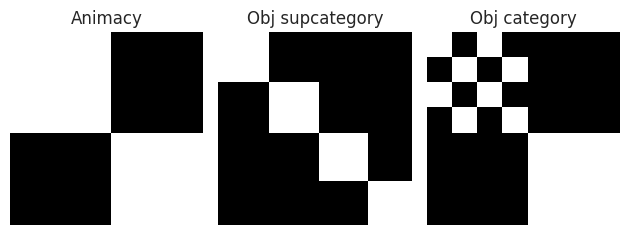

In [16]:
# Create similarity matrices for animacy
animate = df['class1'] == 'animate'
inanimate = df['class1'] == 'inanimate'
corr_animacy = np.corrcoef(np.stack([animate,inanimate], axis =1))

# Create similarity matrices for all object supcategories
human = df['class2'] == 'human'
animal = df['class2'] == 'animal'
natural = df['class2'] == 'natural'
artificial = df['class2'] == 'artificial'
corr_supobj = np.corrcoef(np.stack([human,animal, natural, artificial], axis =1))

#create similarity matrice for object categories
labels = df['class3'].unique()
vecs = list()
for label in labels:
    vecs.append(df['class3'] == label)
corr_obj = np.corrcoef(np.stack(vecs, axis =1))

fig, subs = plt.subplots(1,3)
sns.heatmap(1-corr_animacy,
            annot=False,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[0],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(1-corr_supobj,
            annot=False,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,

            ax = subs[1],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale

sns.heatmap(1-corr_obj,
            annot=False,
            cmap='Greys',      # Blue to red colormap
            square=True,
            cbar=False,
            #cbar_kws={'label': 'Dissimilarity'},
            #fmt='.2f',
            linewidths=0,
            ax = subs[2],
            vmin=0,               # Set minimum value for color scale
            vmax=1)               # Set maximum value for color scale


subs[0].set_title('Animacy')
subs[1].set_title('Obj supcategory')
subs[2].set_title('Obj category')

subs[0].axis('off')
subs[1].axis('off')
subs[2].axis('off')
fig.tight_layout()
plt.show()
fig.savefig('figures/RDM_classes.png', dpi=300, bbox_inches='tight')


In [51]:
def compute_RDMs(model, dataset, listimages, display = True):
    path2activations = f'/data/alban/activations/{model}_{dataset}'
    cls_token = list()
    #patch_token = list()
    for i, im in enumerate(listimages):
        cls_token.append(np.load(join(path2activations, f'cls_token_{im[:-4]}.npy')))
        #patch_token.append(np.load(join(path2activations, f'patch_token_{im[:-4]}.npy')))
    cls_token = np.array(cls_token)
    #corr_cls = np.corrcoef(cls_token.reshape(len(listimages), -1))
    CORRs = list()
    for lay in range(cls_token.shape[1]):
        CORRs.append(np.corrcoef(cls_token[:,lay]))

    #corr_patch = np.corrcoef(patch_token)

    #l2_cls = similarity_L2norm(cls_token)
    #l2_patch = similarity_L2norm(patch_token)

    if display:
        fig, subs = plt.subplots(1,1)
        # Using a different colormap that goes from blue (similar) to red (dissimilar)
        sns.heatmap(1-CORRs[-1],
                    annot=False,
                    cmap='Greys',      # Blue to red colormap
                    square=True,
                    cbar=False,
                    #cbar_kws={'label': 'Dissimilarity'},
                    #fmt='.2f',
                    linewidths=0,
                    ax = subs,
                    vmin=0,               # Set minimum value for color scale
                    vmax=1)               # Set maximum value for color scale


        subs.set_title(f'Trained on {model} and tested on {dataset}')

        subs.axis('off')
        fig.tight_layout()
        plt.show()
        fig.savefig(f'figures/RDM_{model}_{dataset}.png', dpi=300, bbox_inches='tight')
        return CORRs#, l2_cls



We made a list of all the files of activatin

['stimulus1.tif', 'stimulus2.tif', 'stimulus3.tif', 'stimulus4.tif', 'stimulus5.tif', 'stimulus6.tif', 'stimulus7.tif', 'stimulus8.tif', 'stimulus9.tif', 'stimulus10.tif', 'stimulus11.tif', 'stimulus12.tif', 'stimulus13.tif', 'stimulus14.tif', 'stimulus15.tif', 'stimulus16.tif', 'stimulus17.tif', 'stimulus18.tif', 'stimulus19.tif', 'stimulus20.tif', 'stimulus21.tif', 'stimulus22.tif', 'stimulus23.tif', 'stimulus24.tif', 'stimulus25.tif', 'stimulus26.tif', 'stimulus27.tif', 'stimulus28.tif', 'stimulus29.tif', 'stimulus30.tif', 'stimulus31.tif', 'stimulus32.tif', 'stimulus33.tif', 'stimulus34.tif', 'stimulus35.tif', 'stimulus36.tif', 'stimulus37.tif', 'stimulus38.tif', 'stimulus39.tif', 'stimulus40.tif', 'stimulus41.tif', 'stimulus42.tif', 'stimulus43.tif', 'stimulus44.tif', 'stimulus45.tif', 'stimulus46.tif', 'stimulus47.tif', 'stimulus48.tif', 'stimulus49.tif', 'stimulus50.tif', 'stimulus51.tif', 'stimulus52.tif', 'stimulus53.tif', 'stimulus54.tif', 'stimulus55.tif', 'stimulus56.tif', 

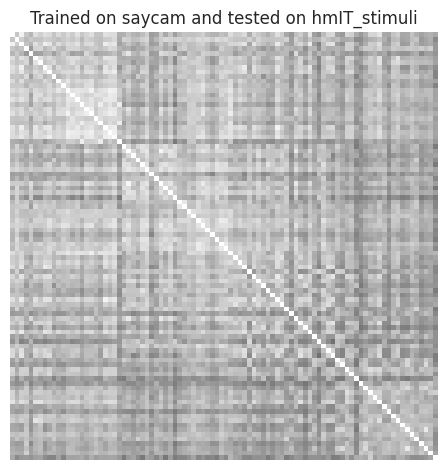

In [52]:
dataset = 'hmIT_stimuli' # alternatively 100_faces or hm_IT_stimuli
path2dataset = f'testsets/{dataset}'


listimages = os.listdir(path2dataset)
listimages = natsorted(listimages) # for hm_IT dataset or
print(listimages)

corr_saycam = compute_RDMs('saycam', dataset, listimages)

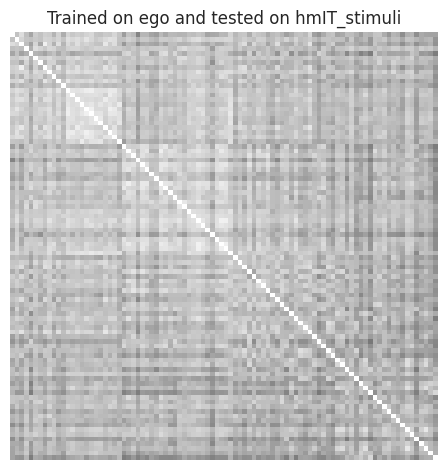

In [53]:
corr_ego = compute_RDMs('ego', dataset, listimages)


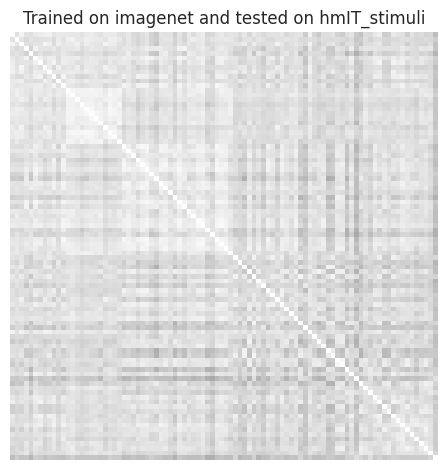

In [54]:
corr_imagenet = compute_RDMs('imagenet', dataset,  listimages)

In [55]:
def Compute_sim_RDMs(RDM1, RDM2):#
    '''
    Function to compute correlational similarity between 2 RDMs.
    Only considers the upper triangular part, excluding the diagonal
    '''
    # Extract upper triangular part (excluding diagonal)
    n = len(RDM1)
    if n != len(RDM2):
        print('RDMs are of different sizes')
    upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
    upper_RDM1 = RDM1[upper_indices]
    upper_RDM2 = RDM2[upper_indices]

    # compute correlations
    return np.corrcoef(upper_RDM1, upper_RDM2)[0,1]


The correlation between saycam and ego is 0.72695934179058.
The correlation between saycam and imagenet is 0.646729334518298.
The correlation between imagenet and ego is 0.7291871395939579.


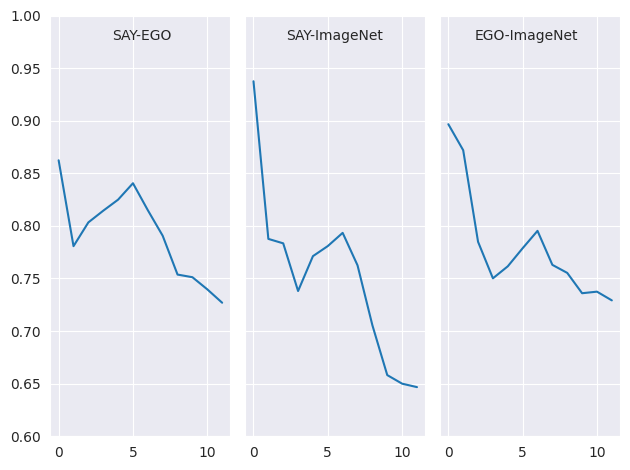

In [71]:
SIM_say_ego = list()
SIM_say_imagenet = list()
SIM_ego_imagenet = list()
for lay in range(len(corr_saycam)):
    SIM_say_ego.append(Compute_sim_RDMs(corr_saycam[lay], corr_ego[lay]))
    SIM_say_imagenet.append(Compute_sim_RDMs(corr_saycam[lay], corr_imagenet[lay]))
    SIM_ego_imagenet.append(Compute_sim_RDMs(corr_ego[lay], corr_imagenet[lay]))

print(f'The correlation between saycam and ego is {SIM_say_ego[-1]}.')
print(f'The correlation between saycam and imagenet is {SIM_say_imagenet[-1]}.')
print(f'The correlation between imagenet and ego is {SIM_ego_imagenet[-1]}.')

fig, subs = plt.subplots(1,3, sharex=True, sharey=True)
subs[0].plot(SIM_say_ego)
subs[1].plot(SIM_say_imagenet)
subs[2].plot(SIM_ego_imagenet)
plt.ylim(0.6,1)
fig.text(0.23, 0.90, 'SAY-EGO', ha='center', va='bottom')
fig.text(0.53, 0.90, 'SAY-ImageNet', ha='center', va='bottom')
fig.text(0.83, 0.90, 'EGO-ImageNet', ha='center', va='bottom')
fig.tight_layout()

In [59]:
corr_saycam[lay].shape

(92, 92)

In [ ]:
### for comparison, load the RDMs from humans and monkeys
RDM_humans = np.loadtxt('testsets/metadata_hmIT/RDM_hIT_fig1.txt')
RDM_monkeys = np.loadtxt('testsets/metadata_hmIT/RDM_mIT_fig1.txt')

def display_RDM(RDM, model):
    '''
    Function to display RDM in a figure as heatmaps.
    '''
    fig, subs = plt.subplots(1,1)
    # Using a different colormap that goes from blue (similar) to red (dissimilar)
    sns.heatmap(RDM,
                annot=False,
                cmap='Greys',      # Blue to red colormap
                square=True,
                cbar=True,
                cbar_kws={'label': 'Dissimilarity'},
                #fmt='.2f',
                linewidths=0,
                ax = subs,
                vmin=0,               # Set minimum value for color scale
                vmax=1)               # Set maximum value for color scale

    subs.set_title('correlation')
    subs.axis('off')
    fig.tight_layout()
    plt.show()
    fig.savefig(f'figures/RDM_{model}.png', dpi=300, bbox_inches='tight')

display_RDM(RDM_humans, 'humans')
display_RDM(RDM_monkeys, 'monkeys')

In [36]:
sim_saycam_humans = Compute_sim_RDMs(1-corr_saycam, RDM_humans)
sim_imagenet_humans = Compute_sim_RDMs(1-RDM_humans, corr_imagenet)
sim_ego_humans = Compute_sim_RDMs(1-RDM_humans, corr_ego)

print(f'The correlation between saycam and humans is {sim_saycam_humans}.')
print(f'The correlation between imagenet and humans is {sim_imagenet_humans}.')
print(f'The correlation between ego and humans is {sim_ego_humans}.')

The correlation between saycam and humans is 0.22605280364330763.
The correlation between imagenet and humans is 0.19773359880100033.
The correlation between ego and humans is 0.20740886825902452.


In [19]:
print(RDM_humans)
print('\n')
print(1 - corr_ego)


[[0.         0.93562399 0.7147688  ... 0.92500005 1.01060327 0.85074597]
 [0.93562399 0.         0.86443862 ... 0.87201048 0.85979911 0.83556584]
 [0.7147688  0.86443862 0.         ... 1.09599432 0.91960056 0.93516907]
 ...
 [0.92500005 0.87201048 1.09599432 ... 0.         0.76198889 0.76530159]
 [1.01060327 0.85979911 0.91960056 ... 0.76198889 0.         0.77501698]
 [0.85074597 0.83556584 0.93516907 ... 0.76530159 0.77501698 0.        ]]


[[1.11022302e-16 3.53106275e-01 2.28915138e-01 ... 4.55659305e-01
  4.57498227e-01 4.58681897e-01]
 [3.53106275e-01 0.00000000e+00 2.74070989e-01 ... 4.04331058e-01
  3.92436693e-01 5.03401648e-01]
 [2.28915138e-01 2.74070989e-01 0.00000000e+00 ... 4.52048082e-01
  4.10766632e-01 5.15109301e-01]
 ...
 [4.55659305e-01 4.04331058e-01 4.52048082e-01 ... 0.00000000e+00
  3.85273300e-01 4.24861535e-01]
 [4.57498227e-01 3.92436693e-01 4.10766632e-01 ... 3.85273300e-01
  0.00000000e+00 4.14929610e-01]
 [4.58681897e-01 5.03401648e-01 5.15109301e-01 ... 4.2

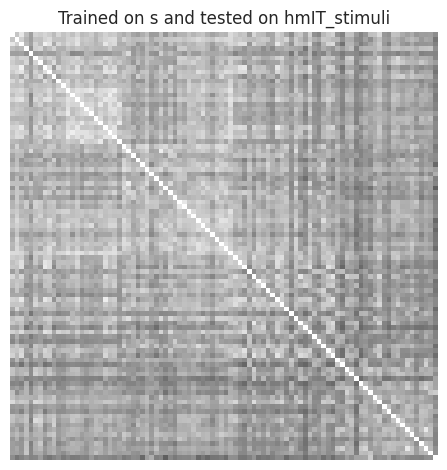

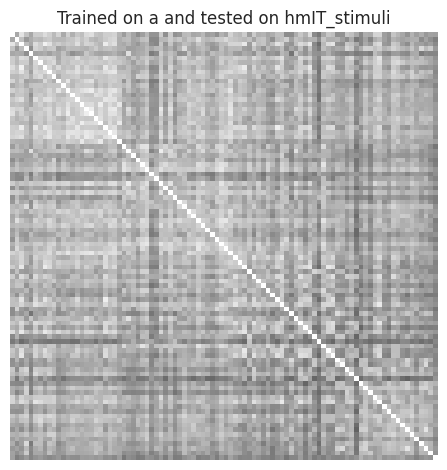

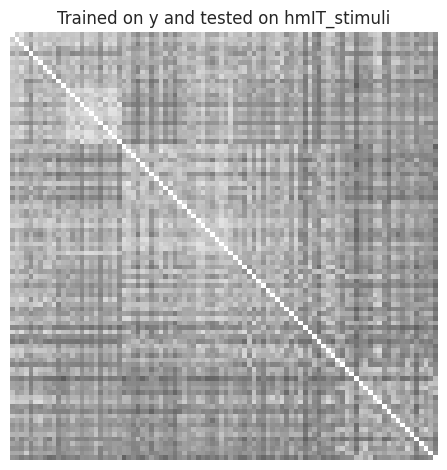

In [21]:
### Do the analysis for models trained individually on s, a and y.
corr_s, l2_s = compute_RDMs('s', dataset, listimages)
corr_a, l2_a = compute_RDMs('a', dataset, listimages)
corr_y, l2_y = compute_RDMs('y', dataset, listimages)


In [22]:
sim_s_a = Compute_sim_RDMs(corr_s, corr_a)
sim_s_y = Compute_sim_RDMs(corr_s, corr_y)
sim_a_y = Compute_sim_RDMs(corr_a, corr_y)

print(f'The correlation between s and a is {sim_s_a}.')
print(f'The correlation between s and y is {sim_s_y}.')
print(f'The correlation between a and y is {sim_a_y}.')

sim_say_s = Compute_sim_RDMs(corr_saycam, corr_s)
sim_say_a = Compute_sim_RDMs(corr_saycam, corr_a)
sim_say_y = Compute_sim_RDMs(corr_saycam, corr_y)

print(f'The correlation between say and s is {sim_say_s}.')
print(f'The correlation between say and a is {sim_say_a}.')
print(f'The correlation between say and y is {sim_say_y}.')

sim_humans_s = Compute_sim_RDMs(RDM_humans, 1-corr_s)
sim_humans_a = Compute_sim_RDMs(RDM_humans, 1-corr_a)
sim_humans_y = Compute_sim_RDMs(RDM_humans, 1-corr_y)

print(f'The correlation between humans and s is {sim_humans_s}.')
print(f'The correlation between humans and a is {sim_humans_a}.')
print(f'The correlation between humans and y is {sim_humans_y}.')

The correlation between s and a is 0.8587661085706404.
The correlation between s and y is 0.8172561261432746.
The correlation between a and y is 0.7885826912005173.
The correlation between say and s is 0.8794045348999774.
The correlation between say and a is 0.856077609442466.
The correlation between say and y is 0.8216615822197079.
The correlation between humans and s is 0.28566532404990785.
The correlation between humans and a is 0.21555697924134187.
The correlation between humans and y is 0.27317868087784614.


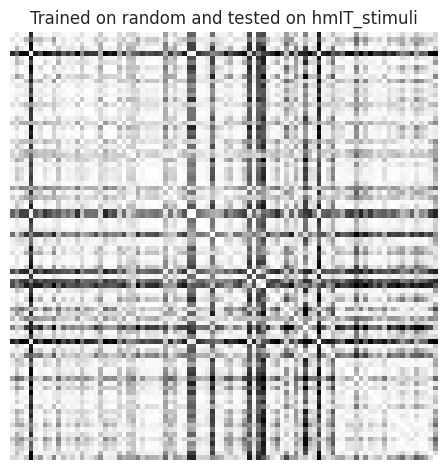

The correlation between say and s is 0.3291068994323753.
The correlation between ego and a is 0.29033804450023204.
The correlation between imagenet and y is 0.3799250934152273.


In [23]:
### Random model
### Do the analysis for models trained individually on s, a and y.
corr_random, l2_s = compute_RDMs('random', dataset, listimages)

sim_say_rand = Compute_sim_RDMs(corr_saycam, corr_random)
sim_ego_rand = Compute_sim_RDMs(corr_ego, corr_random)
sim_imagenet_rand = Compute_sim_RDMs(corr_imagenet, corr_random)

print(f'The correlation between say and s is {sim_say_rand}.')
print(f'The correlation between ego and a is {sim_ego_rand}.')
print(f'The correlation between imagenet and y is {sim_imagenet_rand}.')

Running t-SNE on dissimilarity matrix...


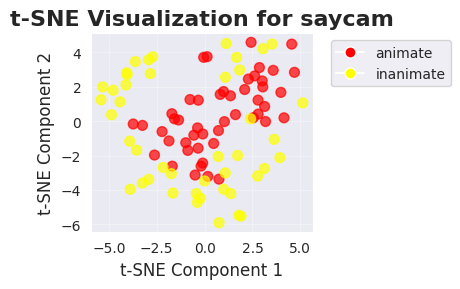

Silhouette Score: 0.102
Number of unique labels: 2

Label distribution:
  animate: 48 images
  inanimate: 44 images
Running t-SNE on dissimilarity matrix...


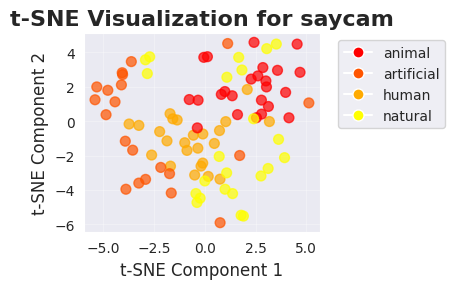

Silhouette Score: 0.083
Number of unique labels: 4

Label distribution:
  animal: 24 images
  artificial: 21 images
  human: 24 images
  natural: 23 images
Running t-SNE on dissimilarity matrix...


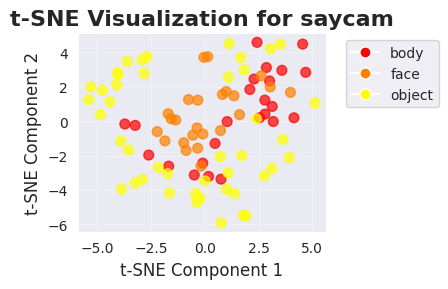

Silhouette Score: -0.029
Number of unique labels: 3

Label distribution:
  body: 24 images
  face: 24 images
  object: 44 images
Running t-SNE on dissimilarity matrix...


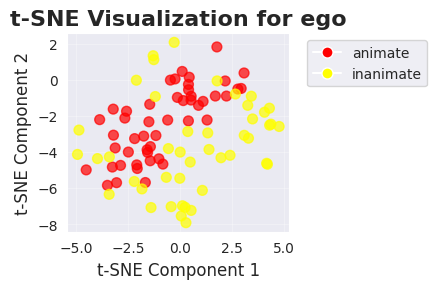

Silhouette Score: 0.123
Number of unique labels: 2

Label distribution:
  animate: 48 images
  inanimate: 44 images
Running t-SNE on dissimilarity matrix...


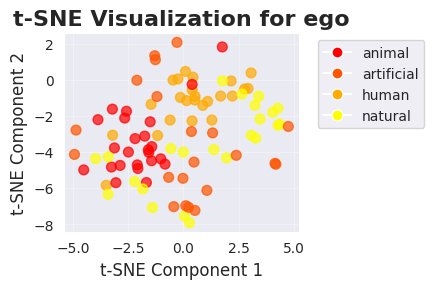

Silhouette Score: 0.069
Number of unique labels: 4

Label distribution:
  animal: 24 images
  artificial: 21 images
  human: 24 images
  natural: 23 images
Running t-SNE on dissimilarity matrix...


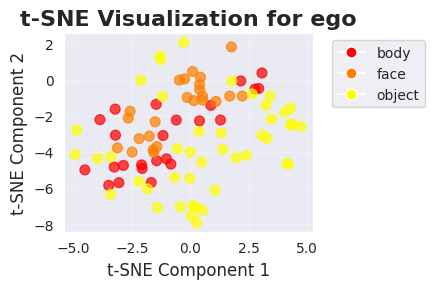

Silhouette Score: -0.001
Number of unique labels: 3

Label distribution:
  body: 24 images
  face: 24 images
  object: 44 images


In [24]:
### Work towards t-sne visualization

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

def tsne_from_dissimilarity_matrix(dissimilarity_matrix, labels, size = 92,
                                 perplexity=30, n_iter=1000, random_state=42):
    """
    Create t-SNE visualization from dissimilarity matrix

    Parameters:
    - dissimilarity_matrix: 100x100 dissimilarity matrix
    - labels: list/array of labels for the 100 images
    - perplexity: t-SNE perplexity parameter
    - n_iter: number of iterations
    - random_state: random seed for reproducibility
    """

    # Ensure dissimilarity matrix is symmetric and valid
    assert dissimilarity_matrix.shape == (size, size), "Matrix must be 100x100"
    assert len(labels) == size, "Must have 100 labels"


    # Run t-SNE with precomputed distances
    tsne = TSNE(n_components=2,
                metric='precomputed',
                perplexity=perplexity,
                max_iter=n_iter,
                random_state=random_state,
                init='random')

    # Fit and transform
    tsne_results = tsne.fit_transform(dissimilarity_matrix)

    return tsne_results

def plot_tsne_results(tsne_results, labels, figsize=(4.5, 3),
                     title="t-SNE Visualization of Image Dissimilarity"):
    """
    Plot t-SNE results with colored labels
    """
    # Encode labels to numbers for coloring
    le = LabelEncoder()
    label_encoded = le.fit_transform(labels)
    unique_labels = le.classes_

    # Create figure
    plt.figure(figsize=figsize)

    # Create scatter plot
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                         c=label_encoded, cmap='autumn',
                         alpha=0.7, s=50)

    # Add labels and title
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)

    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                         markerfacecolor=scatter.cmap(scatter.norm(i)),
                         markersize=8, label=unique_labels[i])
               for i in range(len(unique_labels))]
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add grid
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt.gcf()

def analyze_clusters(tsne_results, labels):
    """
    Analyze cluster quality and separation
    """
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import LabelEncoder

    le = LabelEncoder()
    label_encoded = le.fit_transform(labels)

    # Calculate silhouette score
    sil_score = silhouette_score(tsne_results, label_encoded)

    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Number of unique labels: {len(np.unique(labels))}")

    # Label distribution
    unique, counts = np.unique(labels, return_counts=True)
    print("\nLabel distribution:")
    for label, count in zip(unique, counts):
        print(f"  {label}: {count} images")

    return sil_score

# Example usage and complete pipeline
def complete_tsne_pipeline(dissimilarity_matrix, labels, title):
    """
    Complete example with synthetic data
    """

    print("Running t-SNE on dissimilarity matrix...")

    # Run t-SNE
    tsne_results = tsne_from_dissimilarity_matrix(dissimilarity_matrix, labels)

    # Plot results
    fig = plot_tsne_results(tsne_results, labels, title = title)
    plt.show()

    # Analyze clusters
    analyze_clusters(tsne_results, labels)


    return tsne_results, labels

# Main execution

labels1 = df['class1'] # Animacy
labels2 = df['class2'] # Animacy
labels3 = df['class3'] # Animacy

# For demonstration, run with synthetic data
title="t-SNE Visualization for saycam"
tsne_results, labels = complete_tsne_pipeline(1-corr_saycam, labels1, title)
tsne_results, labels = complete_tsne_pipeline(1-corr_saycam, labels2, title)
tsne_results, labels = complete_tsne_pipeline(1-corr_saycam, labels3, title)

title="t-SNE Visualization for ego"
tsne_results, labels = complete_tsne_pipeline(1-corr_ego, labels1, title)
tsne_results, labels = complete_tsne_pipeline(1-corr_ego, labels2, title)
tsne_results, labels = complete_tsne_pipeline(1-corr_ego, labels3, title)

# 2. Save results
results_df = pd.DataFrame({
    'tsne_x': tsne_results[:, 0],
    'tsne_y': tsne_results[:, 1],
    'label': labels,
    'image_id': range(len(labels))
})
